# Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Load Dataset

In [20]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Target Class Distribution

Text(0, 0.5, 'Frequency')

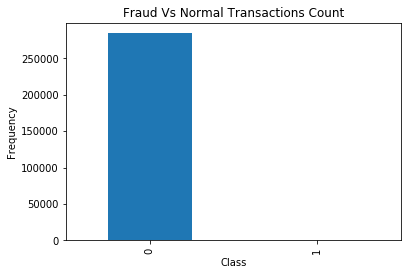

In [7]:
target_count = pd.value_counts(df['Class'])
target_count.plot(kind = 'bar')
plt.title("Fraud Vs Normal Transactions Count")
plt.xlabel("Class")
plt.ylabel("Frequency")

Clearly the data is totally unbalanced!!
- This is a clear example where using a typical accuracy score to evaluate our classification algorithm. For example, if we just used a majority class to assign values to all records, we will still be having a high accuracy, BUT WE WOULD BE CLASSIFYING ALL "1" INCORRECTLY!!
- There are several ways to approach this classification problem taking into consideration this unbalance.
    1. Collect more data? Nice strategy but not applicable in this case
    2. Changing the performance metric:
    3. Use the confusio nmatrix to calculate Precision, Recall
    4. F1score (weighted average of precision recall)
    5. Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data
    6. ROC curves - calculates sensitivity/specificity ratio.
    7. Resampling the dataset
-Essentially this is a method that will process the data to have an approximate 50-50 ratio.
One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class (better when you have little data)
-Another is UNDER-sampling, which deletes instances from the over-represented class (better when he have lot's of data)

### Approach
We are not going to perform feature engineering in first instance. The dataset has been downgraded in order to contain 30 features (28 anonamised + time + amount).
We will then compare what happens when using resampling and when not using it. We will test this approach using a simple logistic regression classifier.
We will evaluate the models by using some of the performance metrics mentioned above.
We will repeat the best resampling/not resampling method, by tuning the parameters in the logistic regression classifier.
We will finally perform classifications model using other classification algorithms.

# Setting our input and target variables + resampling.

## 1. Normalising the amount column. The amount column is not in line with the anonimised features.

In [29]:
from sklearn.preprocessing import StandardScaler
df['normAmount'] = StandardScaler().fit_transform(np.array(df['Amount']).reshape(-1,1))
df = df.drop(['Time','Amount'],axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


## 2. Resampling.

In [33]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']

In [35]:
# Number of data points in the minority class
number_records_fraud = len(df[df.Class == 1])
fraud_indices = np.array(df[df.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = df[df.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = df.iloc[under_sample_indices,:]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


## 3.Splitting data into train and test set. Cross validation will be used when calculating accuracies.

In [36]:
from sklearn.cross_validation import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))

ModuleNotFoundError: No module named 'sklearn.cross_validation'